In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from tqdm.notebook import tqdm

In [ ]:
import os
os.environ['LOGURU_LEVEL'] = 'INFO'

In [ ]:
from ocrpostcorrection.icdar_data import generate_data

In [ ]:
in_dir = Path('../../../data/ICDAR2019_POCR_competition_dataset/ICDAR2019_POCR_competition_training_18M_without_Finnish')

In [ ]:
%%time
# Train and val data
data, md = generate_data(in_dir)

7it [01:13, 20.20s/it]2022-08-24 20:32:38.073 | WARNING  | ocrpostcorrection.icdar_data:process_text:185 - UnicodeEncodeError for text ../../../data/ICDAR2019_POCR_competition_dataset/ICDAR2019_POCR_competition_training_18M_without_Finnish/FI/FI1/250.txt; setting score to 1
11it [01:53, 10.28s/it]


CPU times: user 1min 6s, sys: 7.65 s, total: 1min 14s
Wall time: 1min 53s


In [ ]:
md

language       file_name     score  num_tokens  num_input_tokens
0           SL   SL/SL1/29.txt  0.463415           7                 7
1           SL   SL/SL1/15.txt  0.773294         155               246
2           SL  SL/SL1/114.txt  0.019256         268               272
3           SL  SL/SL1/100.txt  0.049887         229               238
4           SL  SL/SL1/128.txt  0.015375         282               286
...        ...             ...       ...         ...               ...
11657       EN  EN/EN1/131.txt  0.076471         147               148
11658       EN  EN/EN1/119.txt  0.718663         173               251
11659       EN   EN/EN1/18.txt  0.053691         237               239
11660       EN   EN/EN1/24.txt  0.374921         248               291
11661       EN   EN/EN1/30.txt  0.079290         156               158

[11662 rows x 5 columns]

In [ ]:
%%time
# test data
in_dir = Path('../../data/ICDAR2019_POCR_competition_dataset/ICDAR2019_POCR_competition_evaluation_4M_without_Finnish')
data_test, md_test = generate_data(in_dir)

5it [00:01,  2.62it/s]2022-04-27 14:43:08.274 | WARNING  | datautils:process_text:180 - UnicodeEncodeError for text ../../data/ICDAR2019_POCR_competition_dataset/ICDAR2019_POCR_competition_evaluation_4M_without_Finnish/BG/BG1/47.txt; setting score to 1
11it [00:29,  2.65s/it]

CPU times: user 17.8 s, sys: 1.72 s, total: 19.5 s
Wall time: 29.2 s


In [ ]:
md_test

language      file_name     score  num_tokens  num_input_tokens
0          SL  SL/SL1/29.txt  0.992495           2               143
1          SL  SL/SL1/15.txt  0.136364          75                81
2          SL  SL/SL1/14.txt  0.132514         114               121
3          SL  SL/SL1/28.txt  0.028439         269               278
4          SL  SL/SL1/16.txt  0.068158         967               995
...       ...            ...       ...         ...               ...
3035       EN  EN/EN1/25.txt  0.054126         212               213
3036       EN  EN/EN1/19.txt  0.038427         201               203
3037       EN  EN/EN1/18.txt  0.191576         118               148
3038       EN  EN/EN1/24.txt  0.410843         232               284
3039       EN  EN/EN1/30.txt  0.130435           4                 4

[3040 rows x 5 columns]

In [ ]:
md.num_tokens.describe()

count    11662.000000
mean       241.053164
std        193.174556
min          0.000000
25%        165.000000
50%        207.000000
75%        237.000000
max       1971.000000
Name: num_tokens, dtype: float64

<AxesSubplot:>

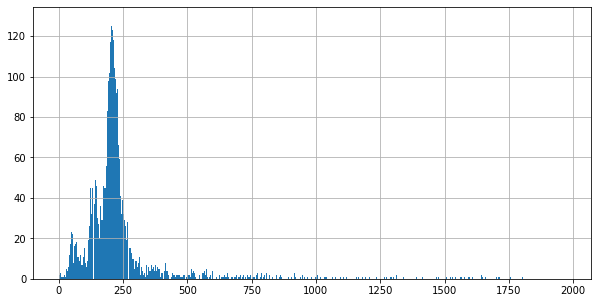

In [ ]:
md.num_tokens.hist(bins=2000, figsize=(10,5))

In [ ]:
md.num_input_tokens.describe()

count    11662.000000
mean       269.510633
std        200.611803
min          0.000000
25%        194.000000
50%        238.000000
75%        267.000000
max       3068.000000
Name: num_input_tokens, dtype: float64

<AxesSubplot:>

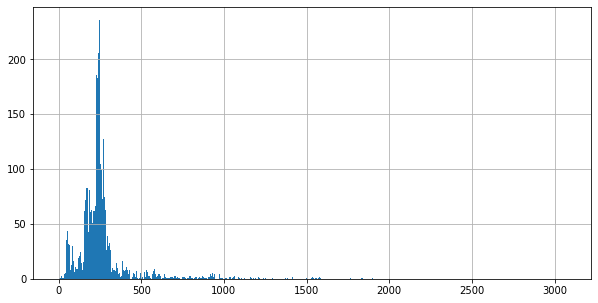

In [ ]:
md.num_input_tokens.hist(bins=2000, figsize=(10,5))

In [ ]:
md.score.describe()

count    11662.000000
mean         0.213732
std          0.127072
min          0.000000
25%          0.125627
50%          0.234702
75%          0.262120
max          1.000000
Name: score, dtype: float64

<AxesSubplot:>

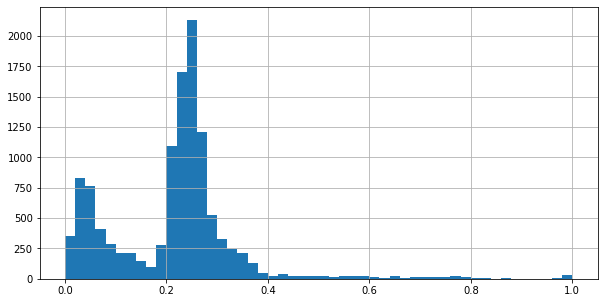

In [ ]:
md.score.hist(bins=50, figsize=(10,5))

In [ ]:
md.query('score <= 0.3').num_tokens.describe()

2022-04-27 14:16:55.247 | INFO     | numexpr.utils:_init_num_threads:157 - NumExpr defaulting to 4 threads.


count    10256.000000
mean       242.158346
std        191.421788
min          2.000000
25%        178.000000
50%        209.000000
75%        236.000000
max       1833.000000
Name: num_tokens, dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, _, _ = train_test_split(md, md['file_name'], test_size=0.1, 
                                        shuffle=True, stratify=md['language'])

In [ ]:
out_dir = Path('icdar-dataset-20220427')
out_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
X_train.to_csv(out_dir/'train.csv')
X_val.to_csv(out_dir/'val.csv')

In [ ]:
X_test = md_test

X_test.to_csv(out_dir/'test.csv')

In [ ]:
in_dir = Path('icdar-dataset-20220207')

X_train = pd.read_csv(in_dir/'train.csv', index_col=0)
X_val = pd.read_csv(in_dir/'val.csv', index_col=0)
X_test = pd.read_csv(in_dir/'test.csv', index_col=0)

In [ ]:
# Generate 'sentences' for train and val sets

from datautils import generate_sentences

sentence_len = 300

train_data = generate_sentences(X_train, data, size=sentence_len, step=sentence_len)
val_data = generate_sentences(X_val, data, size=sentence_len, step=sentence_len)
test_data = generate_sentences(X_test, data_test, size=sentence_len, step=sentence_len)

10282it [00:42, 398.72it/s]2022-04-27 14:44:27.044 | INFO     | datautils:generate_sentences:260 - Empty sample for text "FR/FR3/1023.txt"
2022-04-27 14:44:27.047 | INFO     | datautils:generate_sentences:261 - ocr_str: 
2022-04-27 14:44:27.048 | INFO     | datautils:generate_sentences:262 - start token: 0
10495it [00:43, 241.08it/s]
230it [00:01, 134.67it/s]2022-04-27 14:44:28.943 | INFO     | datautils:generate_sentences:260 - Empty sample for text "FR/FR3/227.txt"
2022-04-27 14:44:28.947 | INFO     | datautils:generate_sentences:261 - ocr_str: 
2022-04-27 14:44:28.950 | INFO     | datautils:generate_sentences:262 - start token: 0
1167it [00:06, 190.47it/s]
3040it [00:16, 184.25it/s]


In [ ]:
train_data.head()

key  start_token_id     score  \
0   FR/FR1/499.txt               0  0.037872   
1   DE/DE6/535.txt               0  0.318182   
2   FR/FR3/406.txt               0  0.036907   
3  DE/DE3/5287.txt               0  0.248340   
4  DE/DE3/2410.txt               0  0.235811   

                                              tokens  \
0  [Johannes,, Dei, gratia,, Francorum, rex., Not...   
1  [Hap, groie, kummer, dapr, van, effen, an, aec...   
2  [Bienvenue, chez, Carrefour, <#», ANGOULINS, T...   
3  [Zonfärbung, borgefragen, don, der, Bfügßge,, ...   
4  [bistvcilen, ,, als, wenn, feinen, ,, ja, felb...   

                                                tags language  
0  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...       FR  
1  [1, 1, 0, 1, 0, 1, 2, 0, 1, 0, 1, 2, 1, 1, 1, ...       DE  
2  [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...       FR  
3  [1, 1, 1, 0, 1, 1, 2, 1, 1, 0, 1, 1, 0, 1, 1, ...       DE  
4  [1, 2, 0, 0, 1, 2, 0, 1, 0, 1, 1, 2, 0, 1, 0, ...       DE

In [ ]:
train_data.query('start_token_id > 0')

key  start_token_id     score  \
20     FI/FI1/295.txt             300  0.062316   
21     FI/FI1/295.txt             600  0.061417   
22     FI/FI1/295.txt             900  0.045927   
43      DE/DE2/98.txt             300  0.260073   
58      NL/NL1/82.txt             300  0.015900   
...               ...             ...       ...   
11476  FI/FI1/242.txt             300  0.110528   
11477  FI/FI1/242.txt             600  0.126214   
11478  FI/FI1/242.txt             900  0.173408   
11479  FI/FI1/242.txt            1200  0.062829   
11480  FI/FI1/242.txt            1500  0.080153   

                                                  tokens  \
20     [muosisadan, alkupimlella., Lehden, päätoimitt...   
21     [kestäviä, tuonta, eri, lasia,, joista, valmis...   
22     [Teeskennellyt, puoluejaot, omat, yhtä, turhat...   
43     [Ansehung, ber, S7ad>rlchten,, welche, (ich, v...   
58     [mede, een, gedeelte, van, den, kavel, n°., 4,...   
...                                                  ...   
11476  [asehuoneelle, Klo, j., pv-, Junat, lähtervät,...   
11477  [Keuruun, k-)., Keuruu., KriStinankaupunki,, K...   
11478  [50;, kirkkohran, rouma, Moliis, Ahmenasta,, n...   
11479  [Moittoja, maStaanottawak, Seminarin, johtajat...   
11480  [sen, waltion-awun, säilyttämistä,, jota, malt...   

                                                    tags language  
20     [1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, ...       FI  
21     [0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, ...       FI  
22     [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ...       FI  
43     [0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, ...       DE  
58     [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...       NL  
...                                                  ...      ...  
11476  [0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, ...       FI  
11477  [0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, ...       FI  
11478  [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, ...       FI  
11479  [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, ...       FI  
11480  [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       FI  

[1011 rows x 6 columns]

In [ ]:
test_data.head()

key  start_token_id     score  \
0  SL/SL1/29.txt               0  0.994371   
1  SL/SL1/15.txt               0  0.136364   
2  SL/SL1/14.txt               0  0.132333   
3  SL/SL1/28.txt               0  0.028439   
4  SL/SL1/16.txt               0  0.104478   

                                              tokens  \
0  [Sab, ftojn., 4, Sha, li, ti., S$, le., J, She...   
1  [tefts, kraja, zhier, je, -, she.viija, plknia...   
2  [39*, Prekajeno, kravje, vime., ,, 40., Divja,...   
3  [155, Kedar, Jezus, na, verh, gore, perjezdi,,...   
4  [138, <r, pretopla, ali, vrozha,, fe, radi, mo...   

                                                tags language  
0  [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...       SL  
1  [1, 0, 0, 1, 2, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, ...       SL  
2  [1, 1, 0, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, ...       SL  
3  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...       SL  
4  [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, ...       SL

In [ ]:
train_data.to_json(out_dir/'icdar_train.jsonl', orient='records', lines=True)
val_data.to_json(out_dir/'icdar_val.jsonl', orient='records', lines=True)
test_data.to_json(out_dir/'icdar_test.jsonl', orient='records', lines=True)

In [ ]:
from datasets import load_dataset

out_dir = Path('icdar-dataset-20220427')

data_files = {'train': str(out_dir/'icdar_train.jsonl'),
              'val': str(out_dir/'icdar_val.jsonl'),
              'test': str(out_dir/'icdar_test.jsonl')}

icdar_dataset = load_dataset("json", data_files=data_files)

2022-04-27 15:19:14.391 | WARNING  | datasets.builder:_create_builder_config:379 - Using custom data configuration default-0fe4c896278af953
2022-04-27 15:19:14.423 | WARNING  | datasets.builder:download_and_prepare:532 - Reusing dataset json (/Users/janneke/.cache/huggingface/datasets/json/default-0fe4c896278af953/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b)
100%|██████████| 3/3 [00:00<00:00, 12.71it/s]


In [ ]:
icdar_dataset

DatasetDict({
    train: Dataset({
        features: ['key', 'start_token_id', 'score', 'tokens', 'tags', 'language'],
        num_rows: 11505
    })
    val: Dataset({
        features: ['key', 'start_token_id', 'score', 'tokens', 'tags', 'language'],
        num_rows: 1283
    })
    test: Dataset({
        features: ['key', 'start_token_id', 'score', 'tokens', 'tags', 'language'],
        num_rows: 3396
    })
})

In [ ]:
train_data.score.describe()

count    11505.000000
mean         0.206852
std          0.136279
min          0.000000
25%          0.082734
50%          0.231461
75%          0.261834
max          1.000000
Name: score, dtype: float64

<AxesSubplot:>

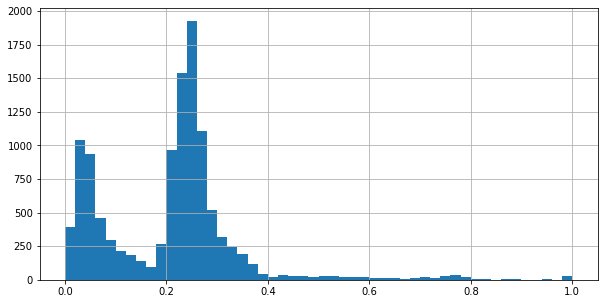

In [ ]:
train_data.score.hist(bins=50, figsize=(10,5))

In [ ]:
val_data.score.describe()

count    1283.000000
mean        0.206952
std         0.141655
min         0.002146
25%         0.079952
50%         0.227713
75%         0.262324
max         1.000000
Name: score, dtype: float64

<AxesSubplot:>

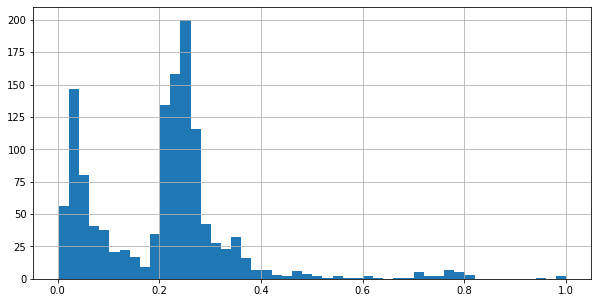

In [ ]:
val_data.score.hist(bins=50, figsize=(10,5))

In [ ]:
icdar_dataset = icdar_dataset.filter(lambda sample: sample['score'] <= 0.3)

100%|██████████| 4/4 [00:04<00:00,  1.02s/ba]


In [ ]:
icdar_dataset

DatasetDict({
    train: Dataset({
        features: ['key', 'start_token_id', 'score', 'tokens', 'tags', 'language'],
        num_rows: 10097
    })
    val: Dataset({
        features: ['key', 'start_token_id', 'score', 'tokens', 'tags', 'language'],
        num_rows: 1114
    })
    test: Dataset({
        features: ['key', 'start_token_id', 'score', 'tokens', 'tags', 'language'],
        num_rows: 2973
    })
})

In [ ]:
icdar_dataset.save_to_disk('icdar-0.3-sent_len-300')

Flattening the indices: 100%|██████████| 3/3 [00:13<00:00,  4.61s/ba]


In [ ]:
from datasets import load_from_disk

icdar_dataset = load_from_disk('icdar-0.3-sent_len-300')

In [ ]:
icdar_dataset

DatasetDict({
    train: Dataset({
        features: ['key', 'start_token_id', 'score', 'tokens', 'tags', 'language'],
        num_rows: 10097
    })
    val: Dataset({
        features: ['key', 'start_token_id', 'score', 'tokens', 'tags', 'language'],
        num_rows: 1114
    })
    test: Dataset({
        features: ['key', 'start_token_id', 'score', 'tokens', 'tags', 'language'],
        num_rows: 2973
    })
})

In [ ]:
import re

def extract_icdar_output(label_str, input_tokens):
    #print(label_str, input_tokens)
    #print(len(label_str), len(input_tokens))
    text_output = {}

    # Correct use of 2 (always following a 1)
    regex = r'12*'

    for match in re.finditer(regex, label_str):
        #print(match)
        #print(match.group())
        num_tokens = len(match.group())
        #print(match.start(), len(input_tokens))
        idx = input_tokens[match.start()].start
        text_output[f'{idx}:{num_tokens}'] = {}

    # Incorrect use of 2 (following a 0) -> interpret first 2 as 1
    regex = r'02+'

    for match in re.finditer(regex, label_str):
        #print(match)
        #print(match.group())
        num_tokens = len(match.group()) - 1
        idx = input_tokens[match.start()+1].start
        text_output[f'{idx}:{num_tokens}'] = {}
    
    return text_output

In [ ]:
data_test['NL/NL1/17.txt']

Text(ocr_text="l VERANTWOORDING. 25 worden uitgevoerd. Dog om dat de vier Predi kanten eigenlijk geen bezwaar hadden tegen de letter van de formulieren en vraagftukken, waar toe de Synode hen bepaald had, maar tegen de applicatie van die letter, fielden zij een ge- fchrift op, waar in zij hunne redenen van be zwaar, tegen het woordelijk voorlezen van de bekende eerfie vraag des Kinderdoops opgeven, en ernftig aandringen, gevende dit fiuk aan de Synodale vergadering binnen Utrecht over, den 7 September 1728. d 1 t gefchrift was ook mede onderteekend door Ds. van schuijlenberg, V. D. M. in Tien• hoven, die reeds te voren, in ’t jaar 1718. in de Clasfis van Utrecht, door een Lidmaat zijner Gemeente was aangeklaagd geweest, dat hij in V lezen van 't formulier van den H. Doop ver- fcheiden veranderingen maakte. Waar op de Clas fis had befloten: „ Dat men te Tienhoven hier „ op onderzoek zou doen, en den Predikant ter „ gerustftelling van zijne Gemeente, door de „ Heeren Gedeputeerden gelast

In [ ]:
from collections import defaultdict

output = defaultdict(dict)

for i, sample in enumerate(icdar_dataset['test']):
    key = sample['key']
    #print(key)
    #print(key, sample['start_token_id'], sample['tags'])
    #print(data_test[key][i].input_tokens)
    label_str = ''.join([str(l) for l in sample['tags']])
    #assert len(label_str) == len(data_test[key].input_tokens[sample['start_token_id']:])
    res = extract_icdar_output(label_str, data_test[key].input_tokens[sample['start_token_id']:sample['start_token_id']+len(sample['tokens'])])
    #print(res)
    output[key].update(res)

In [ ]:
output = dict(output)
output

{'SL/SL1/29.txt': {'0:141': {}, '528:2': {}},
 'SL/SL1/15.txt': {'0:1': {},
  '18:2': {},
  '23:1': {},
  '33:1': {},
  '46:1': {},
  '68:1': {},
  '80:1': {},
  '93:1': {},
  '105:1': {},
  '128:2': {},
  '138:1': {},
  '146:1': {},
  '172:1': {},
  '212:2': {},
  '232:1': {},
  '245:1': {},
  '263:1': {},
  '314:1': {},
  '340:1': {},
  '364:2': {},
  '371:2': {},
  '379:1': {},
  '384:1': {},
  '415:1': {},
  '429:1': {},
  '437:1': {},
  '445:2': {},
  '452:1': {}},
 'SL/SL1/14.txt': {'0:1': {},
  '4:1': {},
  '21:2': {},
  '44:1': {},
  '58:1': {},
  '76:2': {},
  '82:1': {},
  '85:1': {},
  '92:3': {},
  '106:1': {},
  '147:1': {},
  '163:1': {},
  '180:1': {},
  '183:1': {},
  '194:1': {},
  '203:1': {},
  '223:1': {},
  '236:1': {},
  '241:1': {},
  '258:1': {},
  '269:1': {},
  '299:1': {},
  '335:2': {},
  '349:1': {},
  '395:1': {},
  '406:1': {},
  '410:1': {},
  '445:1': {},
  '464:1': {},
  '483:1': {},
  '494:1': {},
  '498:1': {},
  '519:1': {},
  '536:1': {},
  '552:1'

In [ ]:
import json

out_dir = Path('results/icdar-data-20220427-th0.3-sent_len300')
out_dir.mkdir(parents=True, exist_ok=True)

with open(out_dir/'results_task1_perfect.json', 'w') as f:
    json.dump(output, f)

In [ ]:
!python evalTool_ICDAR2017.py ../../data/ICDAR2019_POCR_competition_dataset/ICDAR2019_POCR_competition_evaluation_4M_without_Finnish results/icdar-data-20220427-th0.3-sent_len300/results_task1_perfect.json results/icdar-data-20220427-th0.3-sent_len300/results_task1_perfect.csv

Using:
datasetDirPath: ../../data/ICDAR2019_POCR_competition_dataset/ICDAR2019_POCR_competition_evaluation_4M_without_Finnish 
pathInputJsonErrorsCorrections: results/icdar-data-20220427-th0.3-sent_len300/results_task1_perfect.json 
pathOutputCsv: results/icdar-data-20220427-th0.3-sent_len300/results_task1_perfect.csv

File	NbTokens	NbErroneousTokens	NbSymbolsConsidered	T1_Precision	T1_Recall	T1_Fmesure	T2_AvgLVDistOriginal	T2_AvgLVDistCorrected
SL/SL1/29.txt	2	2	532	1.00	1.00	1.00	0.99	0.99
SL/SL1/15.txt	83	28	404	1.00	1.00	1.00	0.15	0.15
SL/SL1/14.txt	115	50	624	1.00	1.00	1.00	0.16	0.16
SL/SL1/28.txt	273	21	1270	1.00	1.00	1.00	0.03	0.03
SL/SL1/16.txt	1004	182	4838	1.00	0.89	0.94	0.08	0.08
SL/SL1/17.txt	1009	333	4929	1.00	0.89	0.94	0.19	0.19
SL/SL1/13.txt	139	49	715	1.00	1.00	1.00	0.09	0.09
SL/SL1/12.txt	333	30	1491	1.00	0.81	0.89	0.03	0.03
SL/SL1/10.txt	314	36	1278	1.00	1.00	1.00	0.05	0.05
SL/SL1/38.txt	405	33	1995	1.00	0.69	0.82	0.03	0.03
SL/SL1/39.txt	143	73	694	1.00	1.00	1.00	0.15

In [ ]:
out_dir = Path('results/icdar-data-20220427-th0.3-sent_len300')
in_file = out_dir/'results_task1_perfect.csv'

data = pd.read_csv(in_file, sep=';')
data['language'] = data.File.apply(lambda x: x[:2])
data['subset'] = data.File.apply(lambda x: x.split('/')[1])
data

File  NbTokens  NbErroneousTokens  NbSymbolsConsidered  \
0     SL/SL1/29.txt         2                  2                  532   
1     SL/SL1/15.txt        83                 28                  404   
2     SL/SL1/14.txt       115                 50                  624   
3     SL/SL1/28.txt       273                 21                 1270   
4     SL/SL1/16.txt      1004                182                 4838   
...             ...       ...                ...                  ...   
3035  EN/EN1/25.txt       232                 26                  929   
3036  EN/EN1/19.txt       208                 20                  932   
3037  EN/EN1/18.txt       124                 40                  635   
3038  EN/EN1/24.txt       297                 76                 1601   
3039  EN/EN1/30.txt         5                  1                   21   

      T1_Precision  T1_Recall  T1_Fmesure  T2_AvgLVDistOriginal  \
0              1.0       1.00        1.00                  0.99   
1              1.0       1.00        1.00                  0.15   
2              1.0       1.00        1.00                  0.16   
3              1.0       1.00        1.00                  0.03   
4              1.0       0.89        0.94                  0.08   
...            ...        ...         ...                   ...   
3035           1.0       1.00        1.00                  0.06   
3036           1.0       1.00        1.00                  0.05   
3037           1.0       1.00        1.00                  0.22   
3038           1.0       1.00        1.00                  0.39   
3039           1.0       1.00        1.00                  0.14   

      T2_AvgLVDistCorrected language subset  
0                      0.99       SL    SL1  
1                      0.15       SL    SL1  
2                      0.16       SL    SL1  
3                      0.03       SL    SL1  
4                      0.08       SL    SL1  
...                     ...      ...    ...  
3035                   0.06       EN    EN1  
3036                   0.05       EN    EN1  
3037                   0.22       EN    EN1  
3038                   0.39       EN    EN1  
3039                   0.14       EN    EN1  

[3040 rows x 11 columns]

In [ ]:
print(data.groupby('language').mean()[['T1_Precision', 'T1_Recall', 'T1_Fmesure']].to_markdown())

| language   |   T1_Precision |   T1_Recall |   T1_Fmesure |
|:-----------|---------------:|------------:|-------------:|
| BG         |         1      |    0.828776 |     0.897347 |
| CZ         |         1      |    0.966087 |     0.979783 |
| DE         |         1      |    0.982416 |     0.991958 |
| EN         |         1      |    0.956667 |     0.973542 |
| ES         |         1      |    0.91     |     0.9486   |
| FI         |         1      |    0.80825  |     0.8855   |
| FR         |         1      |    0.861689 |     0.919375 |
| NL         |         1      |    0.904898 |     0.944898 |
| PL         |         0.9998 |    0.9336   |     0.9618   |
| SL         |         1      |    0.922917 |     0.94875  |
